# Sedimentation Rate Analysis

### Load dataset and declare indices of variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import geo_preprocess3
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

% matplotlib inline

# load data
data = np.genfromtxt('alldata_new_decomp', delimiter='')

# define column index for 19 variables
lon_ind = 0
lat_ind = 1
sedrate_ind = 2   
sedthick_ind = 3
age_ind = 4
passive_dis_ind = 5
amazon_dis_ind = 6
congo_dis_ind = 7
gange_dis_ind = 8
godava_dis_ind = 9
indus_dis_ind = 10
magdalena_dis_ind = 11
mahan_dis_ind = 12
missi_dis_ind = 13
narma_dis_ind = 14
niger_dis_ind = 15
orin_dis_ind = 16
paleo_dis_ind = 17
parana_dis_ind = 18

river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, paleo_dis_ind, parana_dis_ind])

river_names = np.array(['Amazon', 'Congo', 'Ganges-Bramaputra', 'Godavari-Krishna', 'Indus',
                        'Magdalena', 'Mahanadi', 'Mississipi', 'Narma', 'Niger', 'Orinoco',
                        'Paleo-Congo', 'Parana'])

print(river_indices)
data.shape

[ 6  7  8  9 10 11 12 13 14 15 16 17 18]


(29765, 19)

### Declare the regressor 

In [2]:
% matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# number of splits for LongFold cross validation
n_splits = 3

# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

### Remove records where rate is nan, age is nan, and distance to passive is nan

In [3]:
% matplotlib inline
# remove records where thick is zero
y = data[:, sedthick_ind]
data = data[~(y == 0)]

# remove records where age is nan
y = data[:, age_ind]
data = data[~np.isnan(y)]

# remove records where distance to passive margin is nan
y = data[:, passive_dis_ind]
data = data[~np.isnan(y)]

# remove records where sediment rate is nan or 0
sedrate = data[:, sedrate_ind]
index = (~np.isnan(sedrate)) & (~(sedrate == 0))
data = data[index]

# the final dataset has dimension as follows
data.shape

(27393, 19)

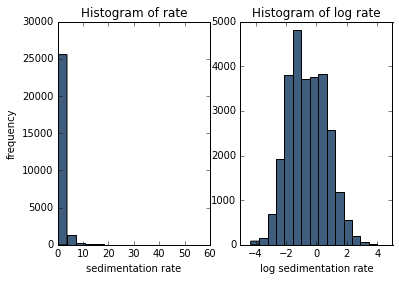

In [4]:
% matplotlib inline
# plot histogram for sedimentation rate and log sedimentation rate
f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[:, [sedrate_ind]], color="#3F5D7D", bins=15)
ax2.hist(np.log(data[:, [sedrate_ind]]), color="#3F5D7D", bins=15)
ax1.set_xlabel('sedimentation rate')
ax1.set_ylabel('frequency')
ax2.set_xlabel('log sedimentation rate')
ax1.set_title('Histogram of rate')
ax2.set_title('Histogram of log rate')
plt.show()

### Define helper functions

In [5]:
% matplotlib inline
def generate_irivers(data, river_indices, maskd=1500.0):
    """Generate inverse of selected rivers from given data."""
    
    rivers = data[:, river_indices]
    
    # mask rivers with distance greater than 1500km
    rivers[rivers > maskd] = np.nan

    rivers[np.isnan(rivers)] = np.inf
    
    return 1.0 / rivers


def compute_model_stats(yactual_lin, ypred_lin, ypred_no_rivers_lin):
    """Compute simple model stats – all values in meters/Ma = cm/ka."""

    yactual_lin_mean = np.mean(yactual_lin)
    print('The observed sed rate mean in cm/ka is:')
    print(yactual_lin_mean)
    
    ypred_lin_mean = np.mean(ypred_lin)
    print('The predicted sed rate mean with rivers is:')
    print(ypred_lin_mean)
    
    ypred_no_rivers_lin_mean = mean=np.mean(ypred_no_rivers_lin)
    print('The predicted sed rate mean without rivers is:')
    print(ypred_no_rivers_lin_mean)
    
    yactual_lin_median = np.median(yactual_lin)
    print('The observed sed rate median is:')
    print(yactual_lin_median)
    
    ypred_lin_median = np.median(ypred_lin)
    print('The predicted sed rate median with rivers is:')
    print(ypred_lin_median)
        
    ypred_no_rivers_lin_median = np.median(ypred_no_rivers_lin)
    print('The predicted sed rate median without rivers is:')
    print(ypred_no_rivers_lin_median)
    
    ypred_diff_lin = ypred_lin-ypred_no_rivers_lin
    
    ypred_diff_mean = mean=np.mean(ypred_diff_lin)
    print('The predicted mean sed rate difference between including or excluding rivers is:')
    print(ypred_diff_mean)

### Train and Predict - with all rivers

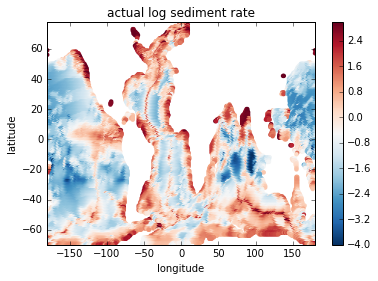

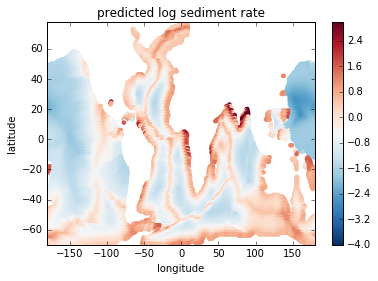

In [6]:
% matplotlib inline
np.seterr(invalid='ignore')

irivers = generate_irivers(data, river_indices)

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = data[:, sedrate_ind]

def compute_r2(weights):
    nr2 = 0.0
    
    # square weights to make sure they are positive
    weights = weights ** 2

    # obtain weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * weights, axis=1)
    
    # integrate all features and target variable into one matrix - data2
    data2 = np.c_[data1, ws_river, sedrate]
    
    # do regression 
    # - this is a function in file geo_preprocess3
    # - it use longitude to do LongFold cross validation
    # - logy=True means apply log transform to target variable y
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    
    # obtain negative r square of actual log rate and predicted log rate
    nr2 = -1.0 * r2_score(yactual, ypred)
    
    # print nr2 to see the process of optimization
    print(nr2)
    return nr2



# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(13)

# here I comment out the command for launching optmization, it takes long time to converge

# res = minimize(fun=compute_r2,
#                x0=w0,
#                method='COBYLA',
#                tol=1e-6,
#                options={'maxiter': 10000,
#                         'disp': True}
# )
# res.x
# opt = res.x
# opt_weights = opt ** 2
# print(tabulate(np.vstack([river_names, opt_weights]).T))

# This is the optimal weights from optimization
opt_weights = np.array([
        0.211881,
        0.423573,
        3.23702,
        0.688782,
        0.338298,
        0.538217,
        0.351286,
        0.830701,
        0.659481,
        0.137399,
        0.501174,
        0.198695,
        0.288485
    ])
ws_river = np.sum(irivers * opt_weights, axis=1)
data2 = np.c_[data1, ws_river, sedrate]
lon = data1[:, lon_ind]
lat = data1[:, lat_ind]
ypred, regressor_trained = geo_preprocess3.regression(data=data2, 
                        regressor=regressor, 
                        n_splits=n_splits,
                        lon_ind=lon_ind, 
                        lat_ind=lat_ind, 
                        y_ind=-1,
                        logy=True)

geo_preprocess3.draw_global(c=np.log(sedrate), 
                       title='actual log sediment rate',
                       longitude=lon, latitude=lat, 
                       vmin=-4, 
                       vmax=3)
geo_preprocess3.draw_global(c=ypred, title='predicted log sediment rate',
                       longitude=lon, latitude=lat,
                       vmin=-4, 
                       vmax=3)


### Train model to learn relationship between only age, margin distance and sedrate

('Mean of age and distance:', array([   57.08516053,  2004.37249998]))
('Variance of age and distance:', array([  1.57169637e+03,   2.43160312e+06]))
('Polynomial coefficients:', array([ 0.        , -0.52275531, -0.51023915,  0.34082993, -0.08491046,
        0.5764176 , -0.0704285 , -0.01460767,  0.1403967 , -0.24019863]))
('Polynomial intercept:', -1.3747666466655577)
('Polynomial feature names:', ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3'])


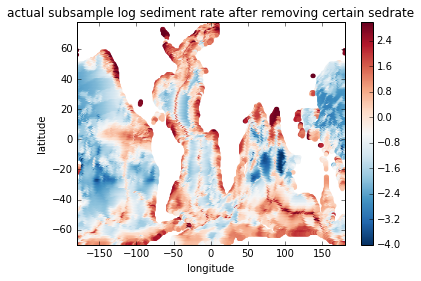

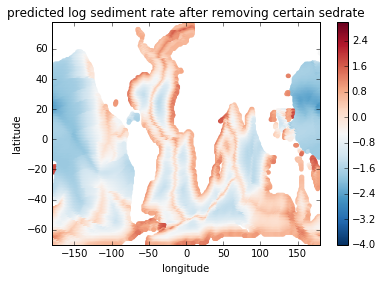

In [7]:
%matplotlib inline
sedrate = data[:, sedrate_ind]
age = data[:, age_ind]

# Here we optionally exclude anomalously high sed rates on relatively young ocean crust following the  
# idea that these might be a recent phenomenon, but for now we have decided not to go down this route

# remove sedrate whose age is 0-26Ma and greater than 0.5 (or some other suitable number)
# indices_remain = ~((age < 26.0) & (sedrate > 0.5))
# datasub = data[indices_remain]
datasub = data

# only use age and margin distance
data_train = datasub[:, [lon_ind, lat_ind, age_ind, passive_dis_ind, sedrate_ind]]

regressor_no_river = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# regression
_, regressor_trained_no_river =  geo_preprocess3.regression(data=data_train, 
                                                                regressor=regressor_no_river, 
                                                                n_splits=n_splits,
                                                                lon_ind=lon_ind, 
                                                                lat_ind=lat_ind, 
                                                                y_ind=-1,
                                                                logy=True)

# Print 
print('Mean of age and distance:', regressor_trained_no_river.named_steps['stand'].mean_)
print('Variance of age and distance:', regressor_trained_no_river.named_steps['stand'].var_)
print('Polynomial coefficients:', regressor_trained_no_river.named_steps['linear'].coef_)
print('Polynomial intercept:', regressor_trained_no_river.named_steps['linear'].intercept_)
print('Polynomial feature names:', regressor_trained_no_river.named_steps['poly'].get_feature_names())

# predict for all samples
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
ypred = geo_preprocess3.predict(data1, regressor_trained_no_river)
yactual_sub = np.log(datasub[:, sedrate_ind])
lon = data[:, lon_ind]
lat = data[:, lat_ind]
lon_sub = datasub[:, lon_ind]
lat_sub = datasub[:, lat_ind]
geo_preprocess3.draw_global(c=yactual_sub, 
                       title='actual subsample log sediment rate after removing certain sedrate',
                       longitude=lon_sub, latitude=lat_sub, 
                       vmin=-4, 
                       vmax=3)
geo_preprocess3.draw_global(c=ypred, title='predicted log sediment rate after removing certain sedrate',
                       longitude=lon, latitude=lat,
                       vmin=-4, 
                       vmax=3)

In [8]:
def period_pred(c_river_indices, period_name, period_index):
    # select subset of data based on period_index
    datapd = data[period_index]

    # extract rivers from datapd, impute nan with infinty, and apply inverse of distance to rivers
    irivers = generate_irivers(datapd, c_river_indices)
    weights = opt_weights[c_river_indices - 6]

    # in this case, use all rivers to get weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * weights, 1)   
    
    # construct matrix for regression
    data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
    sedrate = datapd[:, sedrate_ind]
    data2 = np.c_[data1, ws_river]
    
    # prediction1 - with rivers
    ypred1 =  geo_preprocess3.predict(data2, regressor_trained)

    # prediction2 - with weighted sum of existed rivers
    ypred2 =  geo_preprocess3.predict(data1, regressor_trained_no_river)

    # longitude and latitude for plot
    lon = data1[:,lon_ind]
    lat = data1[:,lat_ind]
    yactual = np.log(sedrate)
    
    # global map of actual log sediment rate
    geo_preprocess3.draw_global(c=np.log(sedrate), 
                           title='actual log sediment rate - '+period_name,
                           longitude=lon, latitude=lat, 
                           vmin=-4, 
                           vmax=3)

    # global map of predicted sediment rate with all features
    geo_preprocess3.draw_global(c=ypred1, title='predicted log sediment rate with rivers '+period_name,
                           longitude=lon, latitude=lat,
                           vmin=-4, 
                           vmax=3)

    # global map of predicted sediment rate with existing rivers
    geo_preprocess3.draw_global(c=ypred2, title='predicted log sediment rate without rivers '+period_name,
                           longitude=lon, latitude=lat,
                           vmin=-4, 
                           vmax=3)

    # global map of difference between prediction with all rivers and with existing rivers
    geo_preprocess3.draw_global(c= (np.exp(ypred1) - np.exp(ypred2)), 
                            title='pred with rivers minus pred without rivers '+period_name,
                           longitude=lon, latitude=lat,
                           vmin=-2, 
                           vmax=2)
    
    return ypred1, ypred2, lon, lat, sedrate

### Train and Predict - Present (exclude Paleo-Congo)

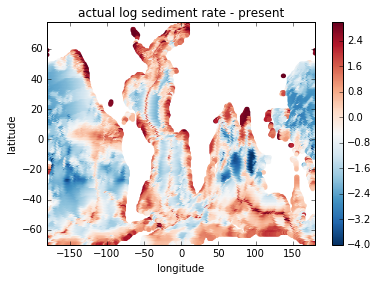

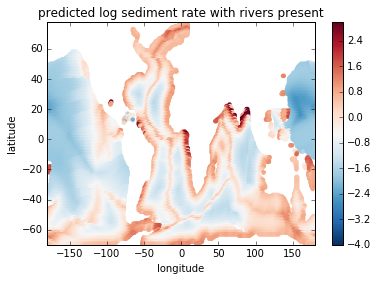

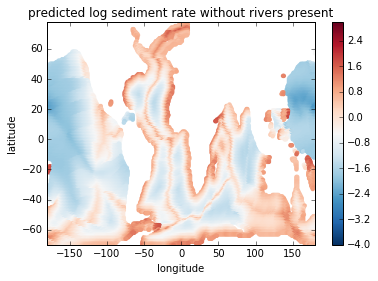

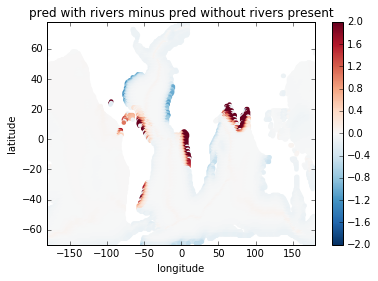

The observed sed rate mean in cm/ka is:
1.23352742961
The predicted sed rate mean with rivers is:
0.830366426451
The predicted sed rate mean without rivers is:
0.776769130653
The observed sed rate median is:
0.512833297253
The predicted sed rate median with rivers is:
0.542323691893
The predicted sed rate median without rivers is:
0.548505716091
The predicted mean sed rate difference between including or excluding rivers is:
0.0535972957982


(27393, 3)

In [9]:
% matplotlib inline
age = data[:, age_ind]

# existing river indices
c_river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, parana_dis_ind])
period_index = (age > 0.0)
c_river_indices.shape
ypresent, ypresent_no_river, lon_present, lat_present, sedrate = period_pred(c_river_indices, 'present',  period_index)

#####

lon = lon_present
lat = lat_present
yactual_lin = sedrate

# Linear observations and predictions
yactual_lin = sedrate
ypred_lin = np.exp(ypresent)
ypred_no_rivers_lin = np.exp(ypresent_no_river)

# compute model stats
compute_model_stats(yactual_lin, ypred_lin, ypred_no_rivers_lin)

# convert 1d into 2d arrays so that individual column arrays can be horizontally stacked/concatenated using hstack

lon2d=np.array(lon).reshape(-1,1)
lat2d=np.array(lat).reshape(-1,1)
ypred_lin2d=np.array(ypred_lin).reshape(-1,1)
ypred_no_rivers_lin2d=np.array(ypred_no_rivers_lin).reshape(-1,1)

# concatenate lon, lat and data columns and save files

# prediction with rivers for present-day
sedrate_withrivers_present = np.hstack((lon2d, lat2d, ypred_lin2d))
np.savetxt("sedrate_withrivers_present.xyz", sedrate_withrivers_present)

# prediction without rivers for present-day
sedrate_norivers_present = np.hstack((lon2d, lat2d, ypred_no_rivers_lin2d))
np.savetxt("sedrate_norivers_present.xyz", sedrate_norivers_present)

# difference in prediction with rivers and observations for present-day sed rates
ydiff_withrivers = yactual_lin - ypred_lin
ydiff_withrivers2d=np.array(ydiff_withrivers).reshape(-1,1)
sedrate_obs_model_diff = np.hstack((lon2d, lat2d, ydiff_withrivers2d))
np.savetxt("sedrate_obs_model_diff_present.xyz", sedrate_obs_model_diff)

# difference in prediction without rivers and observations for present-day sed rates
ydiff_without_rivers = yactual_lin - ypred_no_rivers_lin
ydiff_without_rivers2d=np.array(ydiff_without_rivers).reshape(-1,1)
sedrate_obs_model_without_rivers_diff = np.hstack((lon2d, lat2d, ydiff_without_rivers2d))
np.savetxt("sedrate_obs_model_without_rivers_diff_present.xyz", sedrate_obs_model_without_rivers_diff)

# difference in prediction with and without rivers
ypred_diff = ypred_lin - ypred_no_rivers_lin
ypred_diff2d=np.array(ypred_diff).reshape(-1,1)

sedrate_model_diff = np.hstack((lon2d, lat2d, ypred_diff2d))
np.savetxt("sedrate_model_diff_present.xyz", sedrate_model_diff)

sedrate_withrivers_present.shape

### Train and Predict - 26Ma (exclude Paleo-Congo)

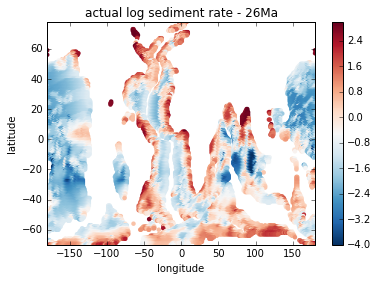

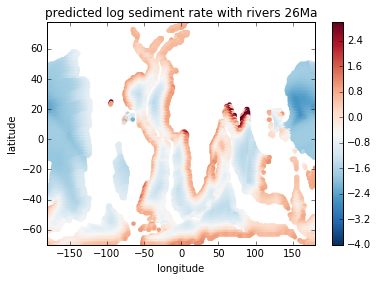

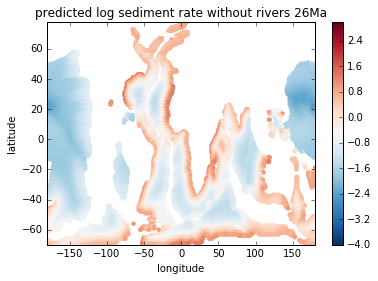

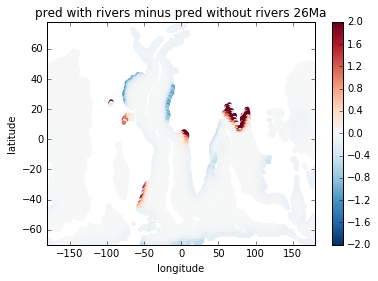

The observed sed rate mean in cm/ka is:
1.04848420138
The predicted sed rate mean with rivers is:
0.698665279346
The predicted sed rate mean without rivers is:
0.645155655744
The observed sed rate median is:
0.374425679445
The predicted sed rate median with rivers is:
0.399626184098
The predicted sed rate median without rivers is:
0.404471091893
The predicted mean sed rate difference between including or excluding rivers is:
0.0535096236023


(19897, 3)

In [10]:
% matplotlib inline
age = data[:, age_ind]

# existing river indices
c_river_indices = np.array([gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          parana_dis_ind])
period_index = (age > 26.0)
c_river_indices.shape
y26, y26_no_river, lon_26, lat_26, sedrate = period_pred(c_river_indices, '26Ma',  period_index)

#####

lon = lon_26
lat = lat_26
yactual_lin = sedrate

# Linear observations and predictions
yactual_lin = sedrate
ypred_lin = np.exp(y26)
ypred_no_rivers_lin = np.exp(y26_no_river)

# compute model stats
compute_model_stats(yactual_lin, ypred_lin, ypred_no_rivers_lin)

# convert 1d into 2d arrays so that individual column arrays can be horizontally stacked/concatenated using hstack

lon2d=np.array(lon).reshape(-1,1)
lat2d=np.array(lat).reshape(-1,1)
ypred_lin2d=np.array(ypred_lin).reshape(-1,1)
ypred_no_rivers_lin2d=np.array(ypred_no_rivers_lin).reshape(-1,1)

# concatenate lon, lat and data columns and save files

# prediction with rivers for 26Ma
sedrate_withrivers_26Ma = np.hstack((lon2d, lat2d, ypred_lin2d))
np.savetxt("sedrate_withrivers_26Ma.xyz", sedrate_withrivers_26Ma)

# prediction without rivers for 26Ma
sedrate_norivers_26Ma = np.hstack((lon2d, lat2d, ypred_no_rivers_lin2d))
np.savetxt("sedrate_norivers_26Ma.xyz", sedrate_norivers_26Ma)

# difference in prediction with rivers and observations for 26Ma sed rates
ydiff_withrivers = yactual_lin - ypred_lin
ydiff_withrivers2d=np.array(ydiff_withrivers).reshape(-1,1)
sedrate_obs_model_diff_26Ma = np.hstack((lon2d, lat2d, ydiff_withrivers2d))
np.savetxt("sedrate_obs_model_diff_26Ma.xyz", sedrate_obs_model_diff_26Ma)

# difference in prediction without rivers and observations for 26Ma sed rates
ydiff_without_rivers = yactual_lin - ypred_no_rivers_lin
ydiff_without_rivers2d=np.array(ydiff_without_rivers).reshape(-1,1)
sedrate_obs_model_without_rivers_diff_26Ma = np.hstack((lon2d, lat2d, ydiff_without_rivers2d))
np.savetxt("sedrate_obs_model_without_rivers_diff_26Ma.xyz", sedrate_obs_model_without_rivers_diff_26Ma)

# difference in prediction with and without rivers
ypred_diff = ypred_lin - ypred_no_rivers_lin
ypred_diff2d=np.array(ypred_diff).reshape(-1,1)

sedrate_model_diff_26Ma = np.hstack((lon2d, lat2d, ypred_diff2d))
np.savetxt("sedrate_model_diff_26Ma.xyz", sedrate_model_diff_26Ma)

sedrate_withrivers_26Ma.shape

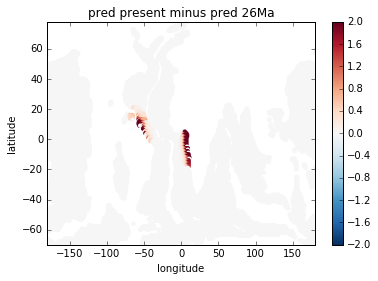

In [11]:
# diff between present and before
lon = data[:, lon_ind]
lat = data[:, lat_ind]
geo_preprocess3.draw_global(c= (np.exp(ypresent[period_index]) - np.exp(y26)), 
                        title='pred present minus pred 26Ma',
                       longitude=lon[period_index], latitude=lat[period_index],
                       vmin=-2, 
                       vmax=2)


### Train and Predict - 56Ma (only Parana, Paleo-Congo, Niger)

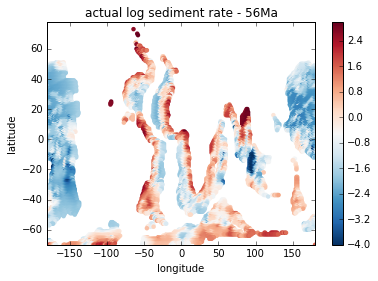

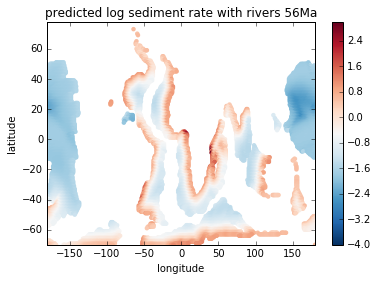

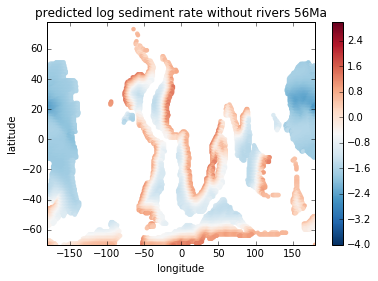

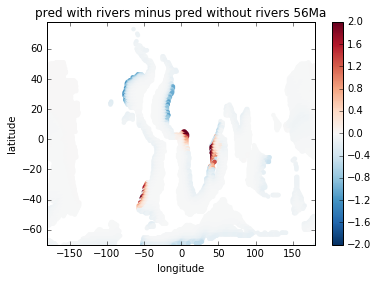

The observed sed rate mean in cm/ka is:
1.04096205742
The predicted sed rate mean with rivers is:
0.622367544983
The predicted sed rate mean without rivers is:
0.639171617972
The observed sed rate median is:
0.351963341236
The predicted sed rate median with rivers is:
0.34678736163
The predicted sed rate median without rivers is:
0.355413188042
The predicted mean sed rate difference between including or excluding rivers is:
-0.0168040729893


(12799, 3)

In [12]:
% matplotlib inline
age = data[:, age_ind]

# existed river indices
c_river_indices = np.array([niger_dis_ind,paleo_dis_ind, parana_dis_ind])

period_index = (age > 56.0)
c_river_indices.shape
y56, y56_no_river, lon_56, lat_56, sedrate = period_pred(c_river_indices, '56Ma',  period_index)

#####

lon = lon_56
lat = lat_56
yactual_lin = sedrate

# Linear observations and predictions
yactual_lin = sedrate
ypred_lin = np.exp(y56)
ypred_no_rivers_lin = np.exp(y56_no_river)

# compute model stats
compute_model_stats(yactual_lin, ypred_lin, ypred_no_rivers_lin)

# convert 1d into 2d arrays so that individual column arrays can be horizontally stacked/concatenated using hstack

lon2d=np.array(lon).reshape(-1,1)
lat2d=np.array(lat).reshape(-1,1)
ypred_lin2d=np.array(ypred_lin).reshape(-1,1)
ypred_no_rivers_lin2d=np.array(ypred_no_rivers_lin).reshape(-1,1)

# concatenate lon, lat and data columns and save files

# prediction with rivers for 56Ma
sedrate_withrivers_56Ma = np.hstack((lon2d, lat2d, ypred_lin2d))
np.savetxt("sedrate_withrivers_56Ma.xyz", sedrate_withrivers_56Ma)

# prediction without rivers for 56Ma
sedrate_norivers_56Ma = np.hstack((lon2d, lat2d, ypred_no_rivers_lin2d))
np.savetxt("sedrate_norivers_56Ma.xyz", sedrate_norivers_56Ma)

# difference in prediction with rivers and observations for 56Ma sed rates
ydiff_withrivers = yactual_lin - ypred_lin
ydiff_withrivers2d=np.array(ydiff_withrivers).reshape(-1,1)
sedrate_obs_model_diff_56Ma = np.hstack((lon2d, lat2d, ydiff_withrivers2d))
np.savetxt("sedrate_obs_model_diff_56Ma.xyz", sedrate_obs_model_diff_56Ma)

# difference in prediction without rivers and observations for 56Ma sed rates
ydiff_without_rivers = yactual_lin - ypred_no_rivers_lin
ydiff_without_rivers2d=np.array(ydiff_without_rivers).reshape(-1,1)
sedrate_obs_model_without_rivers_diff_56Ma = np.hstack((lon2d, lat2d, ydiff_without_rivers2d))
np.savetxt("sedrate_obs_model_without_rivers_diff_56Ma.xyz", sedrate_obs_model_without_rivers_diff_56Ma)

# difference in prediction with and without rivers
ypred_diff = ypred_lin - ypred_no_rivers_lin
ypred_diff2d=np.array(ypred_diff).reshape(-1,1)

sedrate_model_diff_56Ma = np.hstack((lon2d, lat2d, ypred_diff2d))
np.savetxt("sedrate_model_diff_56Ma.xyz", sedrate_model_diff_56Ma)

sedrate_withrivers_56Ma.shape

### Feature Analysis - Age

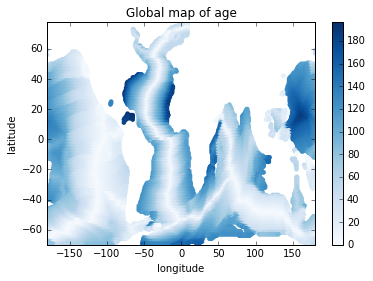

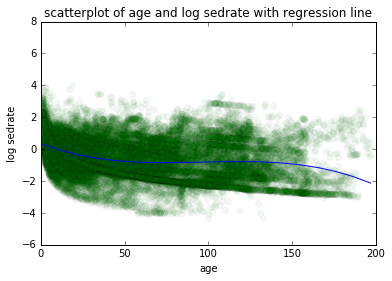

In [13]:
%matplotlib inline
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of age
age = data[:, age_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=age, 
                            title='Global map of age',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=197, 
                            cmap='Blues')

# learn relationship between age and sedrate
regressor.fit(age.reshape(-1,1), np.log(sedrate))
fea_min = np.min(age)
fea_max = np.max(age)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of age and log sedrate
plt.plot(age, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of age and log sedrate with regression line')
plt.xlabel('age')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Distance to passive margin

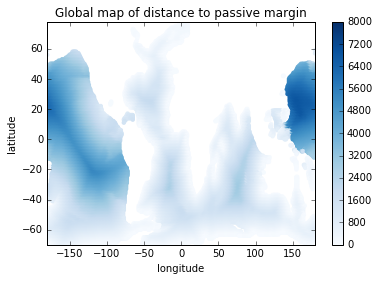

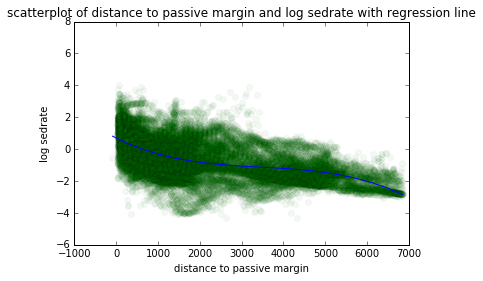

In [14]:
%matplotlib inline
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of distance to passive margine
passive_dis = data[:, passive_dis_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=passive_dis, 
                            title='Global map of distance to passive margin',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=8000,
                            cmap='Blues')

# learn relationship between distance to passive margine and sedrate
regressor.fit(passive_dis.reshape(-1,1), np.log(sedrate))
fea_min = np.min(passive_dis)
fea_max = np.max(passive_dis)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of distance to passive margine and log sedrate
plt.plot(passive_dis, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of distance to passive margin and log sedrate with regression line')
plt.xlabel('distance to passive margin')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Age and Distance to Margin

In [15]:
# Workaround for interactive figure not displaying.
# Error is associated with the console warning "[IPKernelApp] WARNING | No such comm: ".
#
# The workaround obtained from bottom comment at:
#   https://www.bountysource.com/issues/26843647-bug-switching-backend-between-inline-and-qt-or-notebook
#
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook
%matplotlib
%matplotlib notebook

Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg
Using matplotlib backend: nbAgg


Polynomial feature names: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
Polynomial coefficients: [ 0.         -0.37400809 -0.5160163   0.42959    -0.07323361  0.60509602
 -0.12621648 -0.01720338  0.14899377 -0.29455261]


<IPython.core.display.Javascript object>


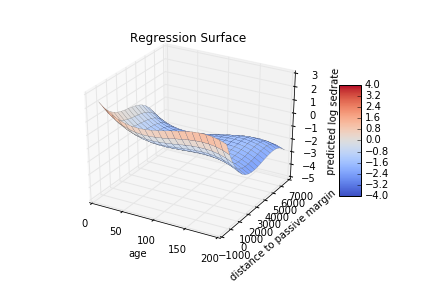

('Mean of age and distance:', array([   60.19000622,  2058.25803042]))
('Variance of age and distance:', array([  1.89421205e+03,   2.96811661e+06]))
('Max of age and distance:', array([  196.88598633,  6855.48388672]))
('Polynomial coefficients:', array([ 0.        , -0.37400809, -0.5160163 ,  0.42959   , -0.07323361,
        0.60509602, -0.12621648, -0.01720338,  0.14899377, -0.29455261]))
('Polynomial intercept:', -1.3607332291017404)
('Polynomial feature names:', ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3'])


In [16]:
dataq = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind, sedrate_ind]]
geo_preprocess3.two_feature_analysis(dataq, regressor, 2, 3, 'age', 
                                     'distance to passive margin', 'predicted log sedrate',
                                     query_size=20)

print('Mean of age and distance:', regressor.named_steps['stand'].mean_)
print('Variance of age and distance:', regressor.named_steps['stand'].var_)
print('Max of age and distance:', np.max(data[:, [age_ind, passive_dis_ind]], axis=0))
print('Polynomial coefficients:', regressor.named_steps['linear'].coef_)
print('Polynomial intercept:', regressor.named_steps['linear'].intercept_)
print('Polynomial feature names:', regressor.named_steps['poly'].get_feature_names())